# How robustness is affected by changing activation functions (elu, kaf, kwta)  

* Craft a PGD-attack for each model from models.ipynb and evaluate robustness
* TODO: Same for a iterative FSG attack
* Plot activations distributions in presence and absence of an attack. Do they differ?

In [1]:
# Imports
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

import activationsf

In [2]:
# Load models and data
from tensorflow.keras.datasets import cifar10

elu_cnn = tf.keras.models.load_model('./light_custom_models/elu_cnn')
kaf_cnn = tf.keras.models.load_model('./light_custom_models/kaf_cnn', custom_objects={'Kaf':activationsf.Kaf})
kwta_cnn = tf.keras.models.load_model('./light_custom_models/kwta_cnn', custom_objects={'Kwta':activationsf.Kwta})

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/ 255.0, x_test/ 255.0

In [ ]:
# Accuracy on test set
elu_cnn.evaluate(x_test, y_test, batch_size=32)
kaf_cnn.evaluate(x_test, y_test, batch_size=32)
kwta_cnn.evaluate(x_test, y_test, batch_size=32)

### Crafting a PGD Attack (Skip this part till robustness eval if attacks are already computed in ./attacks) 

In [ ]:
# We use the IBM Adversarial Robustness 360 Toolbox
!pip install adversarial-robustness-toolbox

In [ ]:
from art.classifiers import TensorFlowV2Classifier
from art.attacks import ProjectedGradientDescent

# Wrap the model in a TensorFlowV2Classifier object
elu_cnn_art = TensorFlowV2Classifier(model=elu_cnn, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), clip_values=(0, 1))
kwta_cnn_art = TensorFlowV2Classifier(model=kwta_cnn, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), clip_values=(0, 1))
kaf_cnn_art = TensorFlowV2Classifier(model=kaf_cnn, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), clip_values=(0, 1))

In [ ]:
# Set up a PGD attack w/ parameters as described in https://arxiv.org/pdf/1905.10510.pdf for each model
pgd_elu = ProjectedGradientDescent(classifier= elu_cnn_art, eps=0.031, eps_step=0.003, max_iter=40, num_random_init=40, norm=np.inf)
pgd_kwta = ProjectedGradientDescent(classifier= kwta_cnn_art, eps=0.031, eps_step=0.003, max_iter=40, num_random_init=40, norm=np.inf)
pgd_kaf = ProjectedGradientDescent(classifier= kaf_cnn_art, eps=0.031, eps_step=0.003, max_iter=40, num_random_init=40, norm=np.inf)

In [ ]:
# If loaded, every output of subsequent cell execution will include the time in min and sec it took to execute it.
#!pip install ipython-autotime
%load_ext autotime

In [ ]:
# Actually compute PGDs (takes around 1h each with GTX1050Ti)

# Get 100 random test samples
# For testing purposes use a much smaller amount of samples, e.g size = 10, 20
sample_ids = np.random.randint(10000, size=100)
x_test_sample = x_test[sample_ids, :, :, :]
elu_x_adv = pgd_elu.generate(x_test_sample)

sample_ids = np.random.randint(10000, size=100)
x_test_sample = x_test[sample_ids, :, :, :]
kwta_x_adv = pgd_kwta.generate(x_test_sample)

sample_ids = np.random.randint(10000, size=100)
x_test_sample = x_test[sample_ids, :, :, :]
kaf_x_adv = pgd_kaf.generate(x_test_sample)

# Save attacks
np.save('./attacks/elu_pgd.npy', elu_x_adv)
np.save('./attacks/kwta_pgd.npy', kwta_x_adv)
np.save('./attacks/kaf_pgd.npy', kaf_x_adv)

### Evaluate Robustness 

In [4]:
# Load computed adversarial examples
elu_x_adv = np.load('./attacks/elu_pgd.npy') 
kwta_x_adv = np.load('./attacks/kwta_pgd.npy') 
kaf_x_adv = np.load('./attacks/kaf_pgd.npy') 

In [5]:
def find_original_img(perturbed_img):
    """Retrieve original image id given an adversarial example""" 
    min_diff = np.math.inf
    index = 0
    
    for i in range(0, x_test.shape[0]):
        diff = np.sum(abs(perturbed_img - x_test[i]))
        if diff < min_diff:
            min_diff = diff
            index = i
            
    return index

In [6]:
# CIFAR10 Classes
classes = ['airplane', 
           'automobile', 
            'bird', 
            'cat', 
            'deer', 
            'dog', 
            'frog', 
            'horse', 
            'ship', 
            'truck']

In [29]:
def attack_succeed(original_img, idx, perturbed_img, model, plot = False):
    """
        Return 0 if the model has been fooled 1 otherwise. Plot True if you want more info su the error margin
    """

    if plot:
        # Plot original img alongside with the perturbed one
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(original_img);
        ax[0].title.set_text('Original')
        ax[0].axis('off')
        ax[1].imshow(perturbed_img)
        ax[1].title.set_text('Perturbed')
        ax[1].axis('off')
        plt.show()
        plt.close()

    # Predict
    perturbed_img = tf.expand_dims(perturbed_img, 0)

    original = classes[y_test[idx][0]]
    perturbed = classes[np.argmax(model.predict(perturbed_img))]

    if plot:
        print("Real class: {}".format(original))
        print("Predicted class: {} with {} confidence".format(perturbed , round(np.max(model.predict(perturbed_img)) * 100)) )

    return (original == perturbed)

In [32]:
# Robustness Accuracy for elu_cnn model, set plot=True if you want image-wise stats
nfool = 0
nacc = 0
for perturbed_img in elu_x_adv:
    
    original_idx = find_original_img(perturbed_img)
    nfool += attack_succeed(x_test[original_idx], original_idx, perturbed_img, elu_cnn, plot=False) 
    nacc += attack_succeed(x_test[original_idx], original_idx, x_test[original_idx], elu_cnn, plot=False) 

print("ELU CNN original Accuracy {}%\nRobustness ELU CNN {}%".format(nacc, nfool))

ELU CNN original Accuracy 75
Robustness ELU CNN 8%


In [34]:
# Robustness Accuracy for kwta_cnn model
nfool = 0
nacc = 0
for perturbed_img in kwta_x_adv:
    
    original_idx = find_original_img(perturbed_img)
    nfool += attack_succeed(x_test[original_idx], original_idx, perturbed_img, kwta_cnn, plot=False) 
    nacc += attack_succeed(x_test[original_idx], original_idx, x_test[original_idx], kwta_cnn, plot=False) 

print("KWTA CNN original Accuracy {}%\nRobustness KWTA CNN {}%".format(nacc, nfool))

KWTA CNN original Accuracy 67%
Robustness KWTA CNN 12%


In [37]:
# Robustness Accuracy for kaf_cnn model
nfool = 0
nacc = 0
for perturbed_img in kaf_x_adv:
    
    original_idx = find_original_img(perturbed_img)
    nfool += attack_succeed(x_test[original_idx], original_idx, perturbed_img, kaf_cnn, plot=False) 
    nacc += attack_succeed(x_test[original_idx], original_idx, x_test[original_idx], kaf_cnn, plot=False) 

print("KAF CNN original Accuracy {}%\nRobustness KAF CNN {}%".format(nacc, nfool))

KAF CNN original Accuracy 73%
Robustness KAF CNN 14%


In [11]:
# Note: here the KAF-net seems to be even more robust than Kwta-net!

## How much does the attack affect activations ?

In [12]:
# Similar function as before but for a batch of adversarial examples
def find_original_ids(perturbed_imgs):
    """Retrive the initially sampled images from a batch of adversarial examples"""    
    original_ids = []
    for img in perturbed_imgs:
        original_ids.append(find_original_img(img))
    
    return x_test[original_ids, :, :, :]

# Get original examples from each attack
elu_test_sample = find_original_ids(elu_x_adv)
kaf_test_sample = find_original_ids(kaf_x_adv)
kwta_test_sample = find_original_ids(kwta_x_adv)

In [13]:
# Compute the activation to the layer of a model for a given input

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, regularizers

def get_hidden_layer_input(model, l_name, inputs, fixed=False):
  ''' Build a sub model of model from buttom layer up to layer l_name.inputs, and return activations to l_name given "inputs" as input'''
  l_inp = model.get_layer(name = l_name).input
  
  if not fixed:
    hidden_model = Model(model.inputs, l_inp)
  
  else: # We need special care when the layer uses a fixed activation function 
    wgts = model.get_layer(name = l_name).get_weights()
    if 'conv' in l_name:
      
      nfilters = model.get_layer(name = l_name).filters
      #recreate the conv2d layer
      if l_name == 'conv2d': #first layer in the model need to add input_shape attribute
        out = layers.Conv2D(nfilters, 3, padding='same', name='out', activation=None, kernel_initializer='he_uniform', input_shape = (32, 32, 3)) (l_inp)
      else:
        out = layers.Conv2D(nfilters, 3, padding='same', name = 'out', activation=None, kernel_initializer='he_uniform') (l_inp)
    
    else:
      nfilters = model.get_layer(name = l_name).units
      #recreate the dense layer
      out = layers.Dense(nfilters, name = 'out', activation=None, kernel_regularizer=regularizers.l2(0.0012)) (l_inp)

    #create the new model
    hidden_model = Model(model.inputs, out)
    #set weights from old layer
    hidden_model.get_layer(name = 'out').set_weights(wgts)
  
  return hidden_model.predict(inputs)

In [14]:
# Same for the output instead of the activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, regularizers

def get_hidden_layer_output(model, l_name, inputs):
  ''' Build a sub model of model from buttom layer up to l_name.ouputs, and return predictions of such model given "inputs" as input'''
  l_out = model.get_layer(name = l_name).output
  hidden_model = Model(model.inputs, l_out)
  return hidden_model.predict(inputs)

In [15]:
# Get Kaf's invariants: kernel bandwidth and dictionary
# Note we just need to pick one random layer of the network which uses kaf since we used the same dicionary size on every layer

# Grab any kaf layer
kaf1 = kaf_cnn.get_layer(name = 'kaf_1')
# Compute delta
delta = abs(kaf1.d[0,0,0,0,1]-kaf1.d[0,0,0,0,0])
kb = 1/(6 * (delta ** 2))
# Compute d
d_tmp = tf.squeeze(kaf1.d)
d = tf.expand_dims(d_tmp, 0)

### Display Kaf/kWTA/ELU activations distributions with and without pgd along hidden layers

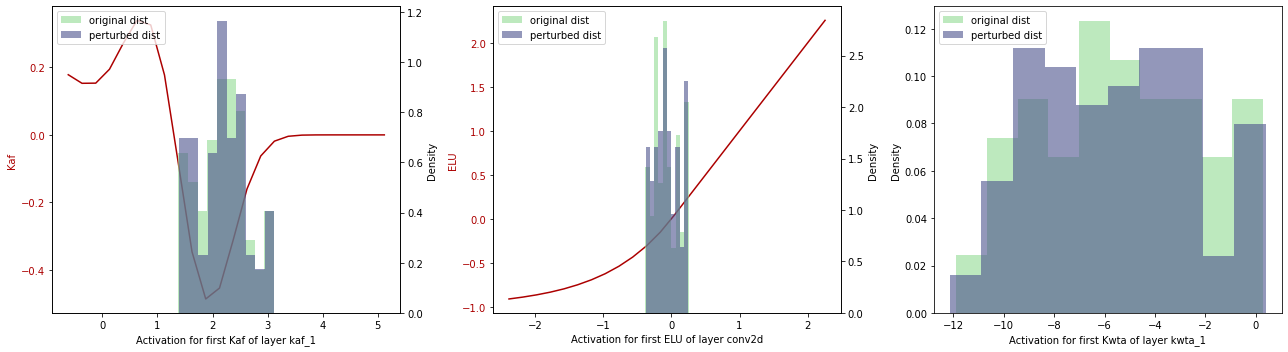

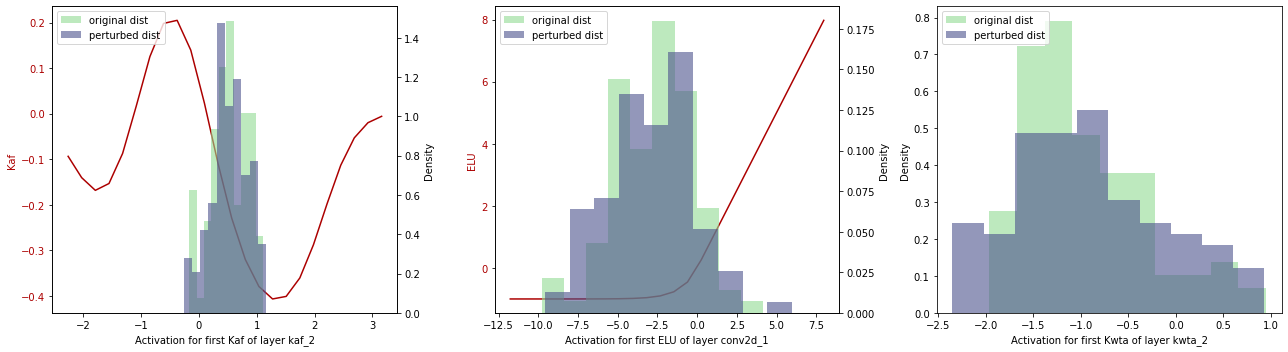

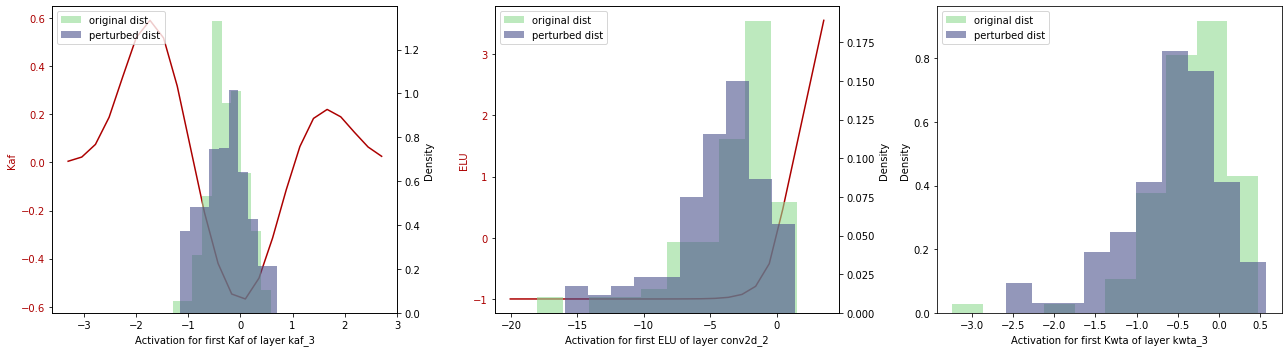

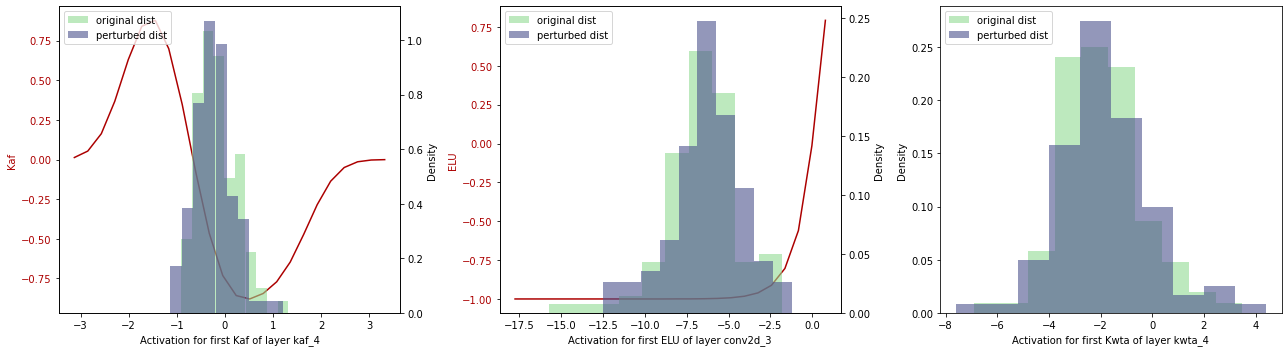

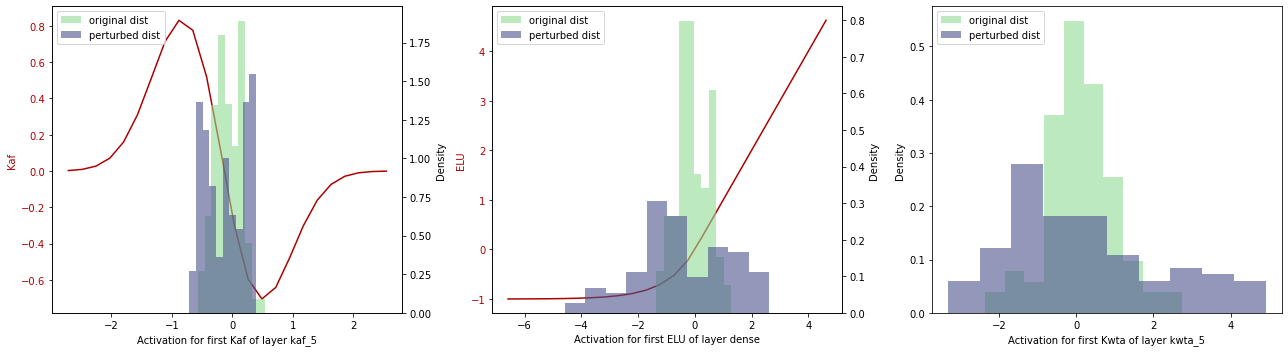

In [16]:
# Display the distribution of the activation value of a specific neuron, for each layer
# Here we just pick always the first(0) neuron, but it should be made many times with different neurons to understand what is going on

first = True
last = 5

for i in range(1, 6): # For each layer
  
  # Get activation function's layer names
  kaf_name = 'kaf_'+str(i)
  kwta_name = 'kwta_'+str(i)
  if first:
    fixed_name = 'conv2d'
    first =False
  elif i == last:
    fixed_name = 'dense'
  else: # In between
    fixed_name = 'conv2d_'+str(i-1)

  # Get the activations to the current (for elu and kwta and kaf) layer when evaluating both original examples and the respective adversarial ones
  elu_inp_orgn = get_hidden_layer_input(elu_cnn, fixed_name, elu_test_sample, fixed = True)
  elu_inp_prt = get_hidden_layer_input(elu_cnn, fixed_name, elu_x_adv, fixed = True)
  
  kwta_inp_orgn = get_hidden_layer_input(kwta_cnn, kwta_name, kwta_test_sample)
  kwta_inp_prt = get_hidden_layer_input(kwta_cnn, kwta_name, kwta_x_adv)
  
  kaf_inp_orgn = get_hidden_layer_input(kaf_cnn, kaf_name, kaf_test_sample)
  kaf_inp_prt = get_hidden_layer_input(kaf_cnn, kaf_name, kaf_x_adv)

  if kaf_inp_orgn.ndim == 4: # If the a.f. is applied on a Conv2d layer
    
    # Get the batch of first activations for the first channel
    elu_act_orgn = elu_inp_orgn[:, 0, 0, 0]
    elu_act_prt = elu_inp_prt[:, 0, 0, 0]

    kwta_act_orgn = kwta_inp_orgn[:, 0, 0, 0]
    kwta_act_prt = kwta_inp_prt[:, 0, 0, 0]

    kaf_act_orgn = kaf_inp_orgn[:, 0, 0, 0]
    kaf_act_prt = kaf_inp_prt[:, 0, 0, 0]
    
  else: # Dense layer otherwise
    
    # Get the batch of activations for the first neuron
    elu_act_orgn = elu_inp_orgn[:, 0]
    elu_act_prt = elu_inp_prt[:, 0]

    kwta_act_orgn = kwta_inp_orgn[:, 0]
    kwta_act_prt = kwta_inp_prt[:, 0]

    kaf_act_orgn = kaf_inp_orgn[:, 0]
    kaf_act_prt = kaf_inp_prt[:, 0]

  # Get mixing coefficients from the first kaf of the layer
  layer = kaf_cnn.get_layer(name = kaf_name)
  a = tf.cast( tf.expand_dims(tf.squeeze(layer.a)[0], 0), dtype = tf.float16 )

  # Input to the activation function to plot a smooth curve
  elu_act = np.concatenate((elu_act_orgn,elu_act_prt))
  min, max = np.min(elu_act), np.max(elu_act)
  elux = np.linspace(min - 2, max + 2, num=24, dtype=np.float16)
  
  kaf_act = np.concatenate((kaf_act_orgn,kaf_act_prt))
  min, max = np.min(kaf_act), np.max(kaf_act)
  kafx = np.linspace(min - 2, max + 2, num=24, dtype=np.float16)
  
  # Compute Kaf and ELU over x
  elu = tf.keras.activations.elu(elux)
  kaf = activationsf.kafActivation(tf.expand_dims(kafx,-1), a, d, kb)
  
  # Plot side by side activation visualizations
  fig, axes = plt.subplots(nrows=1, ncols =3, figsize=(18, 5))
  clr_af = '#ac0000' # function color
  clr_orgn = '#92db93' # orginal activation bins color
  clr_prt = '#4c528c'  # perturbed activation bins color
  
  # Handle Kaf case
  axes[0].set_xlabel('Activation for first Kaf of layer {}'.format(kaf_name))
  axes[0].set_ylabel('Kaf', color=clr_af)
  axes[0].plot(kafx, kaf, color=clr_af)
  axes[0].tick_params(axis='y', labelcolor=clr_af)

  ax01 = axes[0].twinx()  # instantiate a second axes that shares the same x-axis
  ax01.set_ylabel('Density')  # we already handled the x-label with axes0
  ax01.hist(kaf_act_orgn, density=True, color=clr_orgn, bins=10, alpha=0.6, label='original dist')
  ax01.hist(kaf_act_prt, density=True, color=clr_prt, bins=10, alpha=0.6, label='perturbed dist')
  ax01.legend(loc='upper left')
  ax01.tick_params(axis='y')

  # Handle ELU case
  axes[1].set_xlabel('Activation for first ELU of layer {}'.format(fixed_name))
  axes[1].set_ylabel('ELU', color=clr_af)
  axes[1].plot(elux, elu, color=clr_af)
  axes[1].tick_params(axis='y', labelcolor=clr_af)

  ax11 = axes[1].twinx()
  ax11.set_ylabel('Density') 
  ax11.hist(elu_act_orgn, density=True, color=clr_orgn, bins=10, alpha=0.6, label='original dist')
  ax11.hist(elu_act_prt, density=True, color=clr_prt, bins=10, alpha=0.6, label='perturbed dist')
  ax11.legend(loc='upper left')
  ax11.tick_params(axis='y')

  # Handle KWTA case
  # Note: KWTA cant be plotted, show only activation distributions
  axes[2].set_xlabel('Activation for first Kwta of layer {}'.format(kwta_name))
  axes[2].set_ylabel('Density') 
  axes[2].hist(kwta_act_orgn, density=True, color=clr_orgn, bins=10, alpha=0.6, label='original dist')
  axes[2].hist(kwta_act_prt, density=True, color=clr_prt, bins=10, alpha=0.6, label='perturbed dist')
  axes[2].legend(loc='upper left')
  axes[2].tick_params(axis='y')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()
  plt.close()

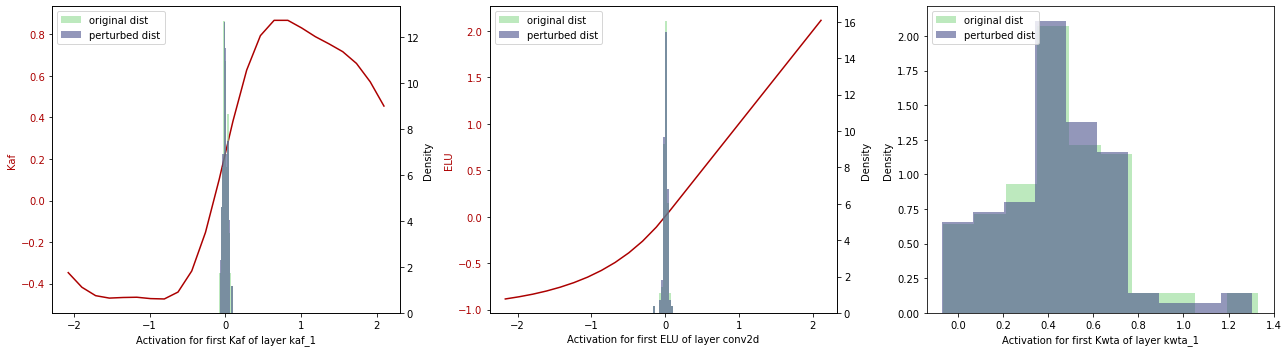

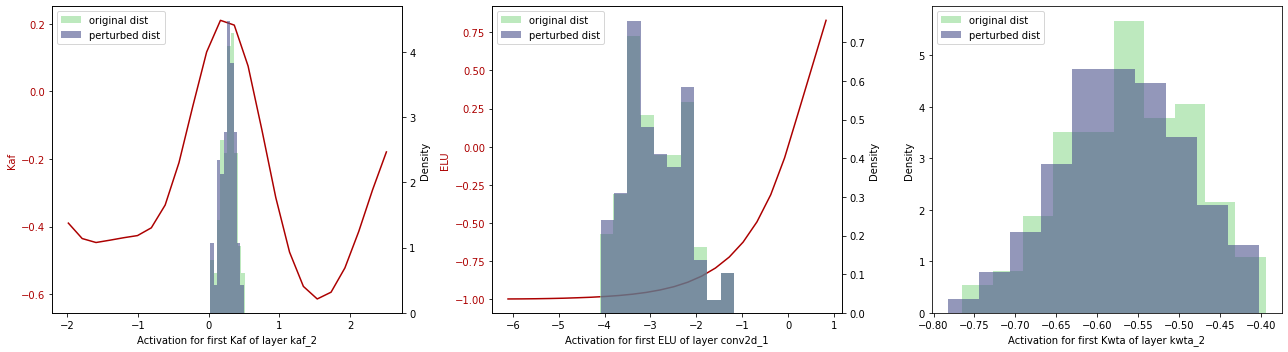

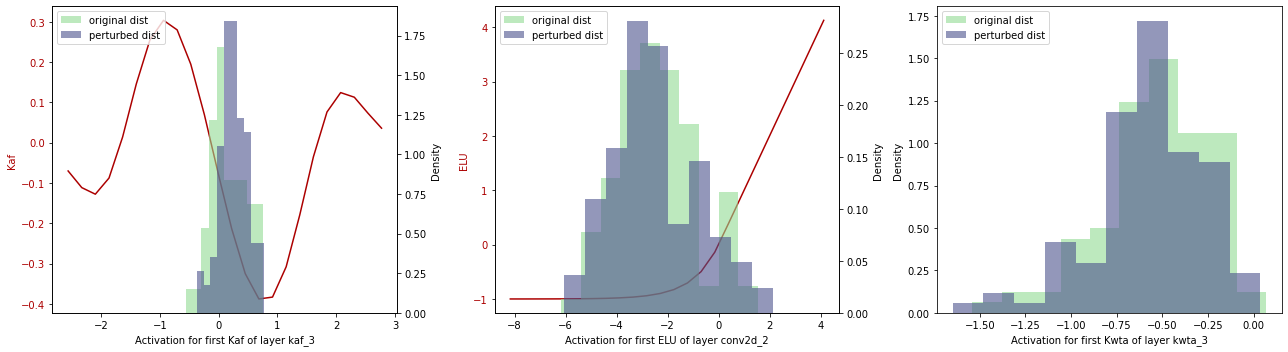

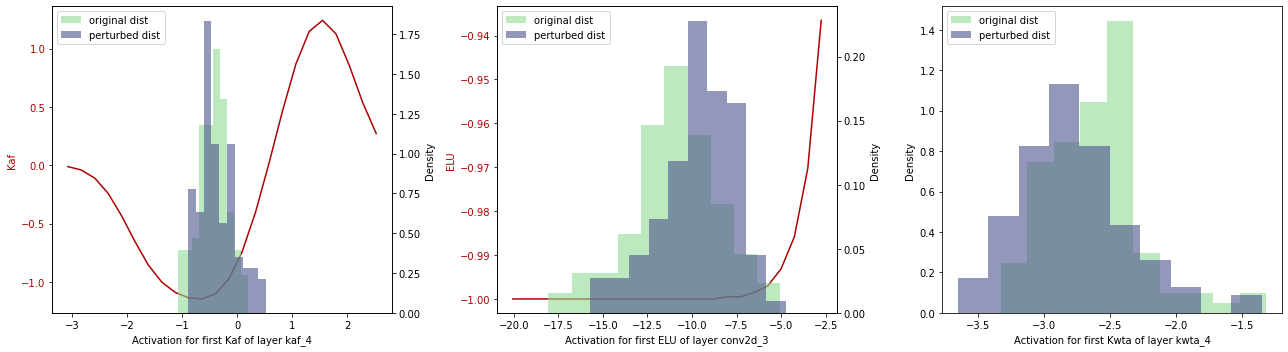

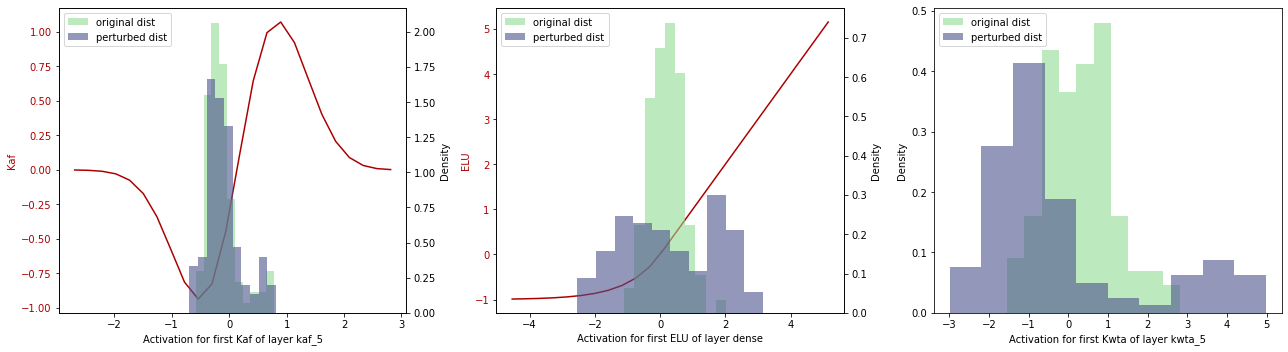

In [18]:
# Here insted we plot the distribution of the average value of a specific channel, for each convolutive layer, same as before otherwise
# Again, we picked the 10*i-th channel but it's arbitrary
# Code is the same as the previous cell except for using a Global average pooling to take the mean value 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # Mute some useless warnings


first = True
last = 5

for i in range(1, 6): # For each activation function 
  
  # Get activation function's layer names
  kaf_name = 'kaf_'+str(i)
  kwta_name = 'kwta_'+str(i)
  if first:
    fixed_name = 'conv2d'
    first =False
  elif i == last:
    fixed_name = 'dense'
  else: # In between
    fixed_name = 'conv2d_'+str(i-1)

  # Get the batch of inputs when predicting the original sample of images and the perturbed ones
  elu_inp_orgn = get_hidden_layer_input(elu_cnn, fixed_name, elu_test_sample, fixed = True)
  elu_inp_prt = get_hidden_layer_input(elu_cnn, fixed_name, elu_x_adv, fixed = True)
  
  kwta_inp_orgn = get_hidden_layer_input(kwta_cnn, kwta_name, kwta_test_sample)
  kwta_inp_prt = get_hidden_layer_input(kwta_cnn, kwta_name, kwta_x_adv)
  
  kaf_inp_orgn = get_hidden_layer_input(kaf_cnn, kaf_name, kaf_test_sample)
  kaf_inp_prt = get_hidden_layer_input(kaf_cnn, kaf_name, kaf_x_adv)

  if kaf_inp_orgn.ndim == 4: # If the a.f. is applied on a Conv2d layer
    
    # Get the average batch of activations for the 10*i-th channel
    elu_act_orgn = tf.keras.layers.GlobalAveragePooling2D()(elu_inp_orgn)[:, 10*i]
    elu_act_prt = tf.keras.layers.GlobalAveragePooling2D()(elu_inp_prt)[:, 10*i]

    kwta_act_orgn = tf.keras.layers.GlobalAveragePooling2D()(kwta_inp_orgn)[:, 10*i]
    kwta_act_prt = tf.keras.layers.GlobalAveragePooling2D()(kwta_inp_prt)[:, 10*i]

    kaf_act_orgn = tf.keras.layers.GlobalAveragePooling2D()(kaf_inp_orgn)[:, 10*i]
    kaf_act_prt = tf.keras.layers.GlobalAveragePooling2D()(kaf_inp_prt)[:, 10*i]
    
  else: # Dense layer otherwise
    
    # Get the batch of activations for the 10*i-th neuron
    elu_act_orgn = elu_inp_orgn[:, 10*i]
    elu_act_prt = elu_inp_prt[:, 10*i]

    kwta_act_orgn = kwta_inp_orgn[:, 10*i]
    kwta_act_prt = kwta_inp_prt[:, 10*i]

    kaf_act_orgn = kaf_inp_orgn[:, 10*i]
    kaf_act_prt = kaf_inp_prt[:, 10*i]

  # Get mixing coefficients from the first kaf of the layer
  layer = kaf_cnn.get_layer(name = kaf_name)
  a = tf.cast( tf.expand_dims(tf.squeeze(layer.a)[10*i], 0), dtype = tf.float16 )

  # Input to the activation function to plot a smooth curve
  elu_act = np.concatenate((elu_act_orgn,elu_act_prt))
  min, max = np.min(elu_act), np.max(elu_act)
  elux = np.linspace(min - 2, max + 2, num=24, dtype=np.float16)
  
  kaf_act = np.concatenate((kaf_act_orgn,kaf_act_prt))
  min, max = np.min(kaf_act), np.max(kaf_act)
  kafx = np.linspace(min - 2, max + 2, num=24, dtype=np.float16)
  
  # Compute Kaf and ELU over x
  elu = tf.keras.activations.elu(elux)
  kaf = activationsf.kafActivation(tf.expand_dims(kafx,-1), a, d, kb)
  
  # Plot side by side activation visualizations
  fig, axes = plt.subplots(nrows=1, ncols =3, figsize=(18, 5))
  clr_af = '#ac0000' # function color
  clr_orgn = '#92db93' # orginal activation bins color
  clr_prt = '#4c528c'  # perturbed activation bins color
  
  # Handle Kaf case
  axes[0].set_xlabel('Activation for first Kaf of layer {}'.format(kaf_name))
  axes[0].set_ylabel('Kaf', color=clr_af)
  axes[0].plot(kafx, kaf, color=clr_af)
  axes[0].tick_params(axis='y', labelcolor=clr_af)

  ax01 = axes[0].twinx()  # instantiate a second axes that shares the same x-axis
  ax01.set_ylabel('Density')  # we already handled the x-label with axes0
  ax01.hist(kaf_act_orgn, density=True, color=clr_orgn, bins=10, alpha=0.6, label='original dist')
  ax01.hist(kaf_act_prt, density=True, color=clr_prt, bins=10, alpha=0.6, label='perturbed dist')
  ax01.legend(loc='upper left')
  ax01.tick_params(axis='y')

  # Handle ELU case
  axes[1].set_xlabel('Activation for first ELU of layer {}'.format(fixed_name))
  axes[1].set_ylabel('ELU', color=clr_af)
  axes[1].plot(elux, elu, color=clr_af)
  axes[1].tick_params(axis='y', labelcolor=clr_af)

  ax11 = axes[1].twinx()
  ax11.set_ylabel('Density') 
  ax11.hist(elu_act_orgn, density=True, color=clr_orgn, bins=10, alpha=0.6, label='original dist')
  ax11.hist(elu_act_prt, density=True, color=clr_prt, bins=10, alpha=0.6, label='perturbed dist')
  ax11.legend(loc='upper left')
  ax11.tick_params(axis='y')

  # Handle KWTA case
  # Note: KWTA cant be plotted, show only activation distributions
  axes[2].set_xlabel('Activation for first Kwta of layer {}'.format(kwta_name))
  axes[2].set_ylabel('Density') 
  axes[2].hist(kwta_act_orgn, density=True, color=clr_orgn, bins=10, alpha=0.6, label='original dist')
  axes[2].hist(kwta_act_prt, density=True, color=clr_prt, bins=10, alpha=0.6, label='perturbed dist')
  axes[2].legend(loc='upper left')
  axes[2].tick_params(axis='y')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()
  plt.close()


## Considerations: It appears that the biggest deviation between orginal and adversarial activations occurs in the last layer, the Dense one before softmax, wihch does make sense if we consider the drop in accuracy when we evaluate on adversarial examples

## In particular, this very raw analysis, seems to suggest that KAF activations are somehow less prone big changes when the input is corrupted

## To quantify, compute, for each hidden layer and activation function, an estimation of the difference in the output when we are evaluating original and adversarial examples.

In [38]:
first = True
last = 5
for i in range(1, 6): # For each layer 
  
  # Get activation function's layer names
  kaf_name = 'kaf_'+str(i)
  kwta_name = 'kwta_'+str(i)
  if first:
    fixed_name = 'conv2d'
    first =False
  elif i == last:
    fixed_name = 'dense'
  else: # In between
    fixed_name = 'conv2d_'+str(i-1)

  # Get the output of the current (for elu and kwta and kaf) layer when predicting both an original example and the respective adversarial one
  elu_out_orgn = get_hidden_layer_output(elu_cnn, fixed_name, tf.expand_dims(elu_test_sample[28], 0)) # We pick 28 but it can be any of the 100 samples
  elu_out_prt = get_hidden_layer_output(elu_cnn, fixed_name, tf.expand_dims(elu_x_adv[28], 0))
  
  kwta_out_orgn = get_hidden_layer_output(kwta_cnn, kwta_name, tf.expand_dims(kwta_test_sample[28], 0))
  kwta_out_prt = get_hidden_layer_output(kwta_cnn, kwta_name, tf.expand_dims(kwta_x_adv[28], 0))
  
  kaf_out_orgn = get_hidden_layer_output(kaf_cnn, kaf_name, tf.expand_dims(kaf_test_sample[28], 0))
  kaf_out_prt = get_hidden_layer_output(kaf_cnn, kaf_name, tf.expand_dims(kaf_x_adv[28], 0))

  if kaf_out_orgn.ndim == 4: # If the a.f. is applied on a Conv2d layer
    
    # Get the average of the output from each channel
    elu_out_orgn = tf.keras.layers.GlobalAveragePooling2D()(elu_out_orgn)
    elu_out_prt = tf.keras.layers.GlobalAveragePooling2D()(elu_out_prt)

    kwta_out_orgn = tf.keras.layers.GlobalAveragePooling2D()(kwta_out_orgn)
    kwta_out_prt = tf.keras.layers.GlobalAveragePooling2D()(kwta_out_prt)

    kaf_out_orgn = tf.keras.layers.GlobalAveragePooling2D()(kaf_out_orgn)
    kaf_out_prt = tf.keras.layers.GlobalAveragePooling2D()(kaf_out_prt)
    
  # Compute and print the difference in the outputs of original and adversarial example as a mean squared error sum
  elu_diff = np.sum((elu_out_orgn - elu_out_prt)**2)
  kaf_diff = np.sum((kaf_out_orgn - kaf_out_prt)**2)
  kwta_diff = np.sum((kwta_out_orgn - kwta_out_prt)**2)
  print("Perturbation Effects at layer {}: ELU {}; KAF {}; KWTA {}".format(i, elu_diff, kaf_diff, kwta_diff))

Perturbation Effects at layer 1: ELU 3.183640001225285e-05; KAF 0.0012255352921783924; KWTA 0.011959630995988846
Perturbation Effects at layer 2: ELU 1.6285778284072876; KAF 0.007219280116260052; KWTA 0.0075450800359249115
Perturbation Effects at layer 3: ELU 13.190267562866211; KAF 0.12269915640354156; KWTA 0.07232654839754105
Perturbation Effects at layer 4: ELU 3.68304443359375; KAF 3.9175002574920654; KWTA 79.95480346679688
Perturbation Effects at layer 5: ELU 145.43994140625; KAF 42.4375; KWTA 502.58172607421875
